<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#ОБЩИЕ-ВЫВОДЫ:" data-toc-modified-id="ОБЩИЕ-ВЫВОДЫ:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>ОБЩИЕ ВЫВОДЫ:</strong></a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [113]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [114]:
def info_about(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    display(data.duplicated().sum())
    display(data.isna().sum())
    display(data.corr())
    data.hist(figsize=(12, 12))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


0

datetime      0
num_orders    0
dtype: int64

,num_orders
num_orders,1.0


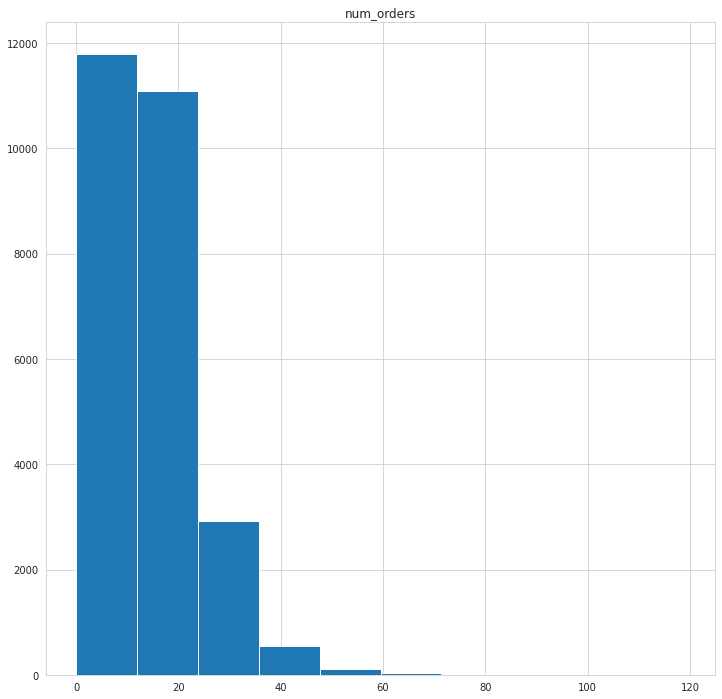

In [115]:
data = pd.read_csv('/datasets/taxi.csv')
info_about(data)

*Есть необходимость в замене типа данных в столбце **datetime**. Пропусков и дубликатов не замечено.*

In [116]:
data['datetime'] = data['datetime'].astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [117]:
data = data.set_index('datetime')

In [118]:
data_1h = data.resample('1H').sum()
data_1h = data_1h.sort_index(ascending=True)
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [119]:
data_1h.index.year.value_counts()

2018    4416
Name: datetime, dtype: int64

### **Вывод:** 

*Пропусков не обнаружено.*

*Дубликатов нет.*

*Изменен тип данных в столбце datetime.*

*Определили столбец datetime индексом data.*

*Осуществили ресемплирование по одному часу.*

## Анализ

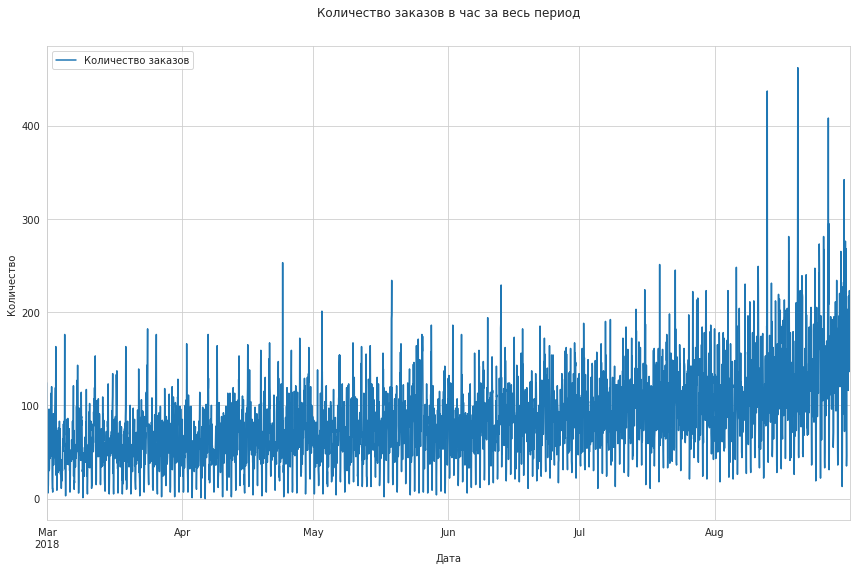

In [120]:
sns.set_style("whitegrid")
data_1h.plot(ax=plt.gca(),figsize=(12,8))
plt.legend(['Количество заказов'])
plt.title('Количество заказов в час за весь период', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

*Замечен рост заказов с июня 2018 года. Посмотрим на тренд, сезонность и остатки.*

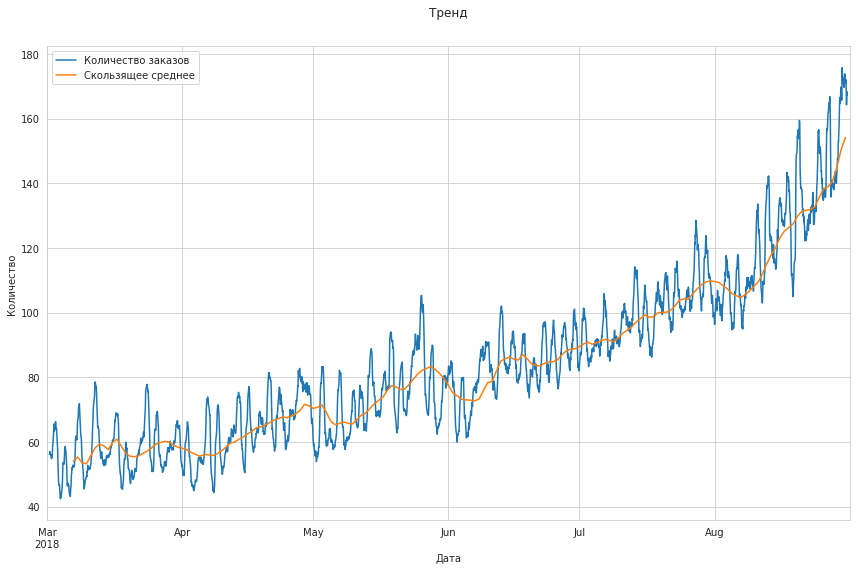

In [121]:
decompose = seasonal_decompose(data_1h)

decompose.trend.plot(ax=plt.gca(),figsize=(12,8))
decompose.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(12,8))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('Тренд', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

*Видим рост, который в принципе начинается даже с марта 2018 года.*

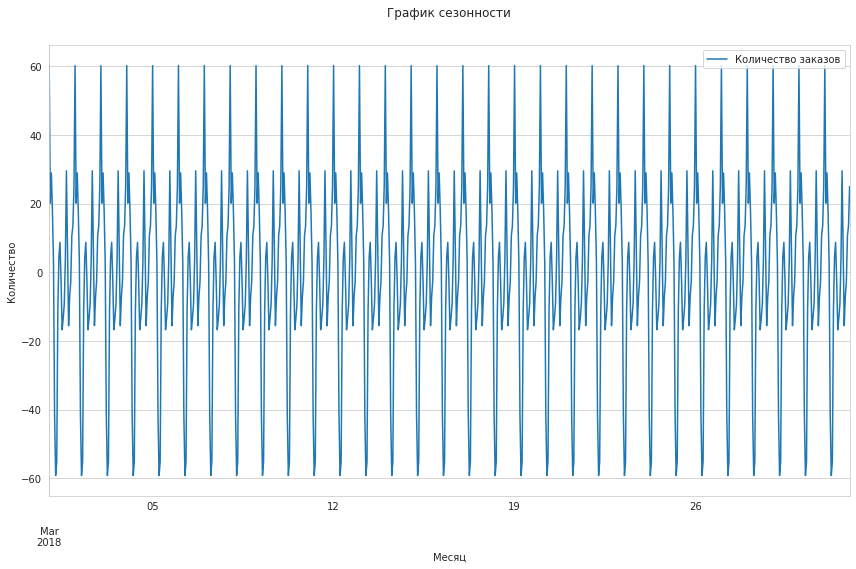

In [122]:
decompose.seasonal['2018-03':'2018-03'].plot(ax=plt.gca(),figsize=(12,8))
plt.legend(['Количество заказов'])
plt.title('График сезонности', y=1.05)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.tight_layout()

In [123]:
display(decompose.seasonal['2018-03':'2018-06'].std(),
        decompose.seasonal['2018-03':'2018-06'].mean().round(),
        decompose.seasonal['2018-06':'2018-09'].std(),
        decompose.seasonal['2018-06':'2018-09'].mean().round())

26.158091620700056

-0.0

26.15954883376102

-0.0

*Сравнив стандартные отклонения и средние значения, которые не меняются, пришли к выводу что на графике сезонности стационарный временной ряд.*  

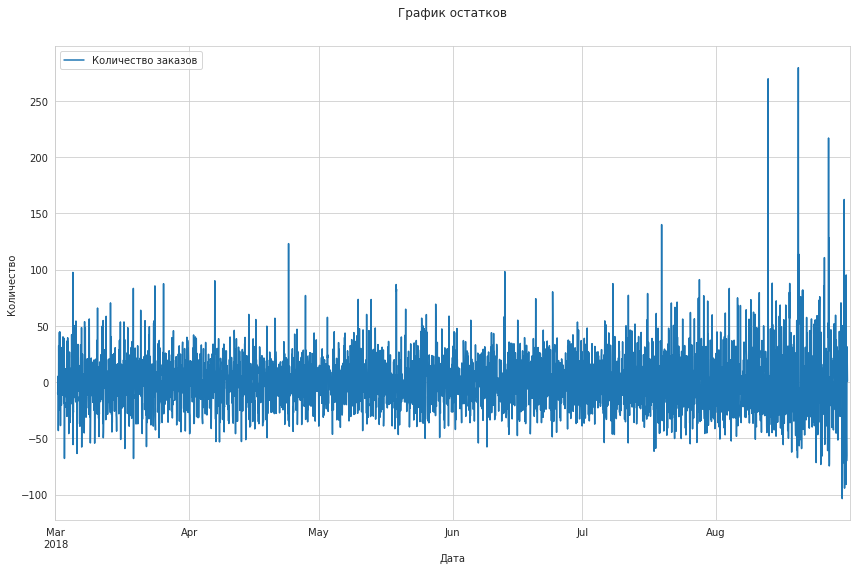

In [124]:
decompose.resid.plot(ax=plt.gca(),figsize=(12,8))
plt.legend(['Количество заказов'])
plt.title('График остатков', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

*Шумные значения пожалуй оставим, для "экономии" данных. Посмотрим что из этого выльется.*

### **Вывод:**

*Изучили тренд, сезонность и остатки.*

*Определили что на графике сезонности стационарный временной ряд.*

*Шумные значения решили оставить*

## Обучение

In [125]:
#Функция для добавления признаков и отстающего значения
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    data['hour']= data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [126]:
#сдвиг в 9 столбцов и скользящее среднее с окном 5 часов
make_features(data_1h, 9, 5)

In [127]:
data_1h.head()

,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
train, test = train_test_split(data_1h, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders',axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders',axis=1)
test_target = test['num_orders']

In [129]:
#Функция для расчёта RMSE
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

**LinearRegression**

In [130]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
predict_lr = model_lr.predict(test_features)
predict_lr = predict_lr.round()
mae_lr = mean_absolute_error(test_target, predict_lr)
rmse_lr = rmse(test_target, predict_lr)
display('MAE LinearRegression:', mae_lr.round(2),
        'RMSE LinearRegression:', rmse_lr)

'MAE LinearRegression:'

40.59

'RMSE LinearRegression:'

53.48

**RandomForestRegressor**

In [131]:
parametrs = { 'n_estimators': range (5, 18),
              'max_depth': range (9, 21)}
split_index = TimeSeriesSplit().split(train_features)
model_rf = RandomForestRegressor(random_state=12345)
grid_rf = GridSearchCV(model_rf, 
                       parametrs, 
                       cv = split_index, 
                       scoring = make_scorer(rmse, greater_is_better=False))
grid_rf.fit(train_features, train_target)

best_score_rf = -1*grid_rf.best_score_

parametrs_r_gs_d = pd.Series(grid_rf.best_params_)[0]
parametrs_r_gs_n = pd.Series(grid_rf.best_params_)[1]
display('RMSE на обучающей выборке: {:.2f}'. format(best_score_rf), 
      'Максимальная глубина:', parametrs_r_gs_d, 
      'Количество деревьев:', parametrs_r_gs_n)

'RMSE на обучающей выборке: 25.94'

'Максимальная глубина:'

18

'Количество деревьев:'

16

In [132]:
predict_rf = grid_rf.predict(test_features)
predict_rf = predict_rf.round()

rmse_rf = rmse(test_target, predict_rf)
print('RMSE RandomForestRegressor:', rmse_rf)

RMSE RandomForestRegressor: 44.41


**CatBoostRegressor**

In [133]:
model_cat = CatBoostRegressor(random_state = 123, 
                              learning_rate = 0.4, 
                              verbose = 100, 
                              n_estimators = 300)
model_cat.fit(train_features, train_target, eval_set = (test_features,test_target))
predict_cat = model_cat.predict(test_features)
predict_cat = predict_cat.round()
rmse_cat=rmse(test_target, predict_cat)

0:	learn: 32.1693765	test: 73.5684094	best: 73.5684094 (0)	total: 3.13ms	remaining: 937ms
100:	learn: 15.0380730	test: 44.2787512	best: 44.2787512 (100)	total: 250ms	remaining: 493ms
200:	learn: 10.9378150	test: 44.6415226	best: 43.8501941 (141)	total: 491ms	remaining: 242ms
299:	learn: 8.2583525	test: 44.7904088	best: 43.8501941 (141)	total: 732ms	remaining: 0us

bestTest = 43.85019407
bestIteration = 141

Shrink model to first 142 iterations.


### **Вывод:**

*Обучили такие модели как LinearRegression, RandomForestRegressor, CatBoostRegressor.*

*Получили следующие значения RMSE:*

- LinearRegression - 53.48

- RandomForestRegressor - 44.41

- CatBoostRegressor - 43.85

## Тестирование

In [134]:
table_wtm = pd.DataFrame(index=['RMSE модели',], columns = ['LinearRegression', 
                                                            'RandomForestRegressor', 
                                                            'CatBoostRegressor'])
table_wtm['LinearRegression'] = rmse_lr
table_wtm['RandomForestRegressor'] = rmse_rf
table_wtm['CatBoostRegressor'] = rmse_cat

table_wtm

,LinearRegression,RandomForestRegressor,CatBoostRegressor
RMSE модели,53.48,44.41,43.86


*Модели RandomForestRegressor и CatBoostRegressor показали себя с лучшей стороны. Но всё же RandomForestRegressor оказался чуть лучше*

In [135]:
model_r = RandomForestRegressor(random_state=12345, n_estimators=16, max_depth=14)
model_r.fit(train_features, train_target)
predict_rf = model_r.predict(test_features)
rmse_rf = rmse(test_target, predict_rf.round())
print('RMSE RandomForestRegressor:', rmse_rf)

RMSE RandomForestRegressor: 44.62


*Итоговое значение RMSE на лучшей модели = 44.62*

## **ОБЩИЕ ВЫВОДЫ:**

У нас стояла задача построить модель для прогноза количества заказов такси на следующий час. Также необходимое для выполнения задания значение метрики RMSE не должно было быть 48.

Был изучен, проанализирован датасет с историческими данными о заказах такси в аэропортах. Вот что было сделано:

- Изменили тип данных в столбце datetime, определили столбец datetime индексом data, осуществили ресемплирование по одному часу;

- Изучили тренд, сезонность и остатки, определили что на графике сезонности стационарный временной ряд, шумные значения решили оставить.

Обучили такие модели как LinearRegression, RandomForestRegressor, CatBoostRegressor.

Получили следующие значения RMSE:

- LinearRegression - 53.48

- RandomForestRegressor - 44.41

- CatBoostRegressor - 43.85

Получили итоговое значение RMSE на лучшей модели = 44.62.

**Рекомендации заказчику:** для предсказания количества заказов такси на следующий час можно смело использовать модель RandomForestRegressor.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48